Notebook to evaluate the difference between resting and task-fc connectivity, in order to validate Cole's results

- Increased task-state FC compared to resting-state FC (without task regression?)

In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import os
from os.path import join as opj
import nibabel as nib
import regex as re
from tqdm import tqdm
from nilearn import image, glm, input_data, plotting, masking
import tempfile
import shutil
from scipy.spatial.distance import squareform
from joblib import load

import sys
sys.path.append("../src")
import os

from cofluctuate_bold_glm import NiftiEdgeAtlas

/home/javi/Documentos/software/nilearn/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/javi/Documentos/software/nilearn/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [14]:
final_subjects = np.loadtxt("../data/subjects_intersect_motion_035.txt")

confounders_regex = "trans|rot|white_matter$|csf$"
print(confounders_regex)

high_pass = 1/187.
print(high_pass)

fir_delays = list(range(1,8))
print(fir_delays)

t_r = 2.0
print(t_r)

first_level_opts = {"smoothing_fwhm" : None, # No smoothing, as we are using parcellated stuff and edge. Not clear how to smooth here...!
                    "t_r" : t_r,
                    "hrf_model" : "glover + derivative + dispersion",
                    "drift_model" : None, # We already  high pass filtered the data
                    "signal_scaling": False, 
                   }

atlas_file = "../../data/shen_2mm_268_parcellation.nii.gz"
atlas_img = image.load_img(atlas_file)
#contrast = 'Incongruent-Congruent'

edge_atlas = NiftiEdgeAtlas(atlas_file = atlas_file, detrend=False, high_pass=high_pass, t_r=t_r, fir_delays=fir_delays)

trans|rot|white_matter$|csf$
0.0053475935828877
[1, 2, 3, 4, 5, 6, 7]
2.0


In [44]:
def compute_connectivity(run_img, conf_df, events):
    
    """
    Function that computes the Pearson correlations.
    This function is just defined in order to gain 
    speed by parallel computations
    
    """
    # Compute edge time series
    edge_img = edge_atlas.fit_transform(run_img=run_img, confounds=conf_df, events=events)
    # Take the average to compute the Pearson correlation
    conn = np.mean(np.squeeze(edge_img.get_fdata()), axis=2)
    # return the upper tringle elements only
    return squareform(conn, checks=False)

# LOAD DATA

In [3]:
from input_data import get_bold_files, get_confounders_df
run_imgs_resting = get_bold_files(task_id="rest", data_dir="../", subjects=final_subjects)
conf_dfs_resting = get_confounders_df(task_id="rest", data_dir="../", subjects=final_subjects)

run_imgs_stroop = get_bold_files(task_id="stroop", data_dir="../", subjects=final_subjects)
conf_dfs_stroop = get_confounders_df(task_id="stroop", data_dir="../", subjects=final_subjects)

run_imgs_msit = get_bold_files(task_id="msit", data_dir="../", subjects=final_subjects)
conf_dfs_msit = get_confounders_df(task_id="msit", data_dir="../", subjects=final_subjects)

# COMPUTE CONNECTIVITY MATRICES

In [ ]:
from joblib import Parallel, delayed
parallel = Parallel(n_jobs=15)

In [18]:
connectivity_resting = parallel(delayed(compute_connectivity)(run_img = run_img, 
                                                              conf_df=conf_df, 
                                                              events=None) \
                                for (run_img, conf_df) \
                                in tqdm(zip(run_imgs_resting, conf_dfs_resting))
                               )

259it [01:18,  3.29it/s]


In [69]:
events = "../data/task-stroop_events.tsv"

connectivity_stroop_before = parallel(delayed(compute_connectivity)(run_img = run_img, 
                                                              conf_df=conf_df, 
                                                              events=None) \
                                for (run_img, conf_df) \
                                in tqdm(zip(run_imgs_stroop, conf_dfs_stroop))
                               )

connectivity_stroop_after = parallel(delayed(compute_connectivity)(run_img = run_img, 
                                                              conf_df=conf_df, 
                                                              events=events) \
                                for (run_img, conf_df) \
                                in tqdm(zip(run_imgs_stroop, conf_dfs_stroop))
                               )

259it [02:31,  1.71it/s]
259it [02:39,  1.62it/s]


In [49]:
events = "../data/task-msit_events.tsv"

connectivity_msit_before = parallel(delayed(compute_connectivity)(run_img = run_img, 
                                                                  conf_df=conf_df, 
                                                                  events=None) \
                                for (run_img, conf_df) \
                                in tqdm(zip(run_imgs_msit, conf_dfs_msit))
                               )

connectivity_msit_after = parallel(delayed(compute_connectivity)(run_img = run_img, 
                                                                 conf_df=conf_df, 
                                                                 events=events) \
                                for (run_img, conf_df) \
                                in tqdm(zip(run_imgs_msit, conf_dfs_msit))
                               )

259it [02:21,  1.84it/s]
259it [02:21,  1.84it/s]


# COMPUTE DIFFERENCES

In [53]:
from scipy.stats import ttest_rel

In [101]:
ttest_rel(np.array(connectivity_stroop_before)[:,0], np.array(connectivity_stroop_after)[:,0])

Ttest_relResult(statistic=3.98573802858932, pvalue=8.761125942358842e-05)

In [116]:
diff_stroop_before_after = [ttest_rel(a,b)[0] \
                            for a,b in zip(np.array(connectivity_stroop_before).T, 
                                           np.array(connectivity_stroop_after).T)]

diff_stroop_before_resting = [ttest_rel(a,b)[0] \
                          for a,b in zip(np.array(connectivity_stroop_before).T, 
                                         np.array(connectivity_resting).T)]
diff_stroop_after_resting = [ttest_rel(a,b)[0] \
                          for a,b in zip(np.array(connectivity_stroop_after).T, 
                                         np.array(connectivity_resting).T)]


diff_msit_before_after = [ttest_rel(a,b)[0] \
                            for a,b in zip(np.array(connectivity_msit_before).T, 
                                           np.array(connectivity_msit_after).T)]

diff_msit_before_resting = [ttest_rel(a,b)[0] \
                          for a,b in zip(np.array(connectivity_msit_before).T, 
                                         np.array(connectivity_resting).T)]
diff_msit_after_resting = [ttest_rel(a,b)[0] \
                          for a,b in zip(np.array(connectivity_msit_after).T, 
                                         np.array(connectivity_resting).T)]

In [126]:
diff_stroop_before_after = [np.mean(a-b) \
                            for a,b in zip(np.array(connectivity_stroop_before).T, 
                                           np.array(connectivity_stroop_after).T)]

diff_stroop_before_resting = [np.mean(a-b) \
                          for a,b in zip(np.array(connectivity_stroop_before).T, 
                                         np.array(connectivity_resting).T)]
diff_stroop_after_resting = [np.mean(a-b) \
                          for a,b in zip(np.array(connectivity_stroop_after).T, 
                                         np.array(connectivity_resting).T)]


diff_msit_before_after = [np.mean(a-b) \
                            for a,b in zip(np.array(connectivity_msit_before).T, 
                                           np.array(connectivity_msit_after).T)]

diff_msit_before_resting = [np.mean(a-b) \
                          for a,b in zip(np.array(connectivity_msit_before).T, 
                                         np.array(connectivity_resting).T)]
diff_msit_after_resting = [np.mean(a-b) \
                          for a,b in zip(np.array(connectivity_msit_after).T, 
                                         np.array(connectivity_resting).T)]

In [130]:
np.max(diff_stroop_after_resting)

0.1874681848229736

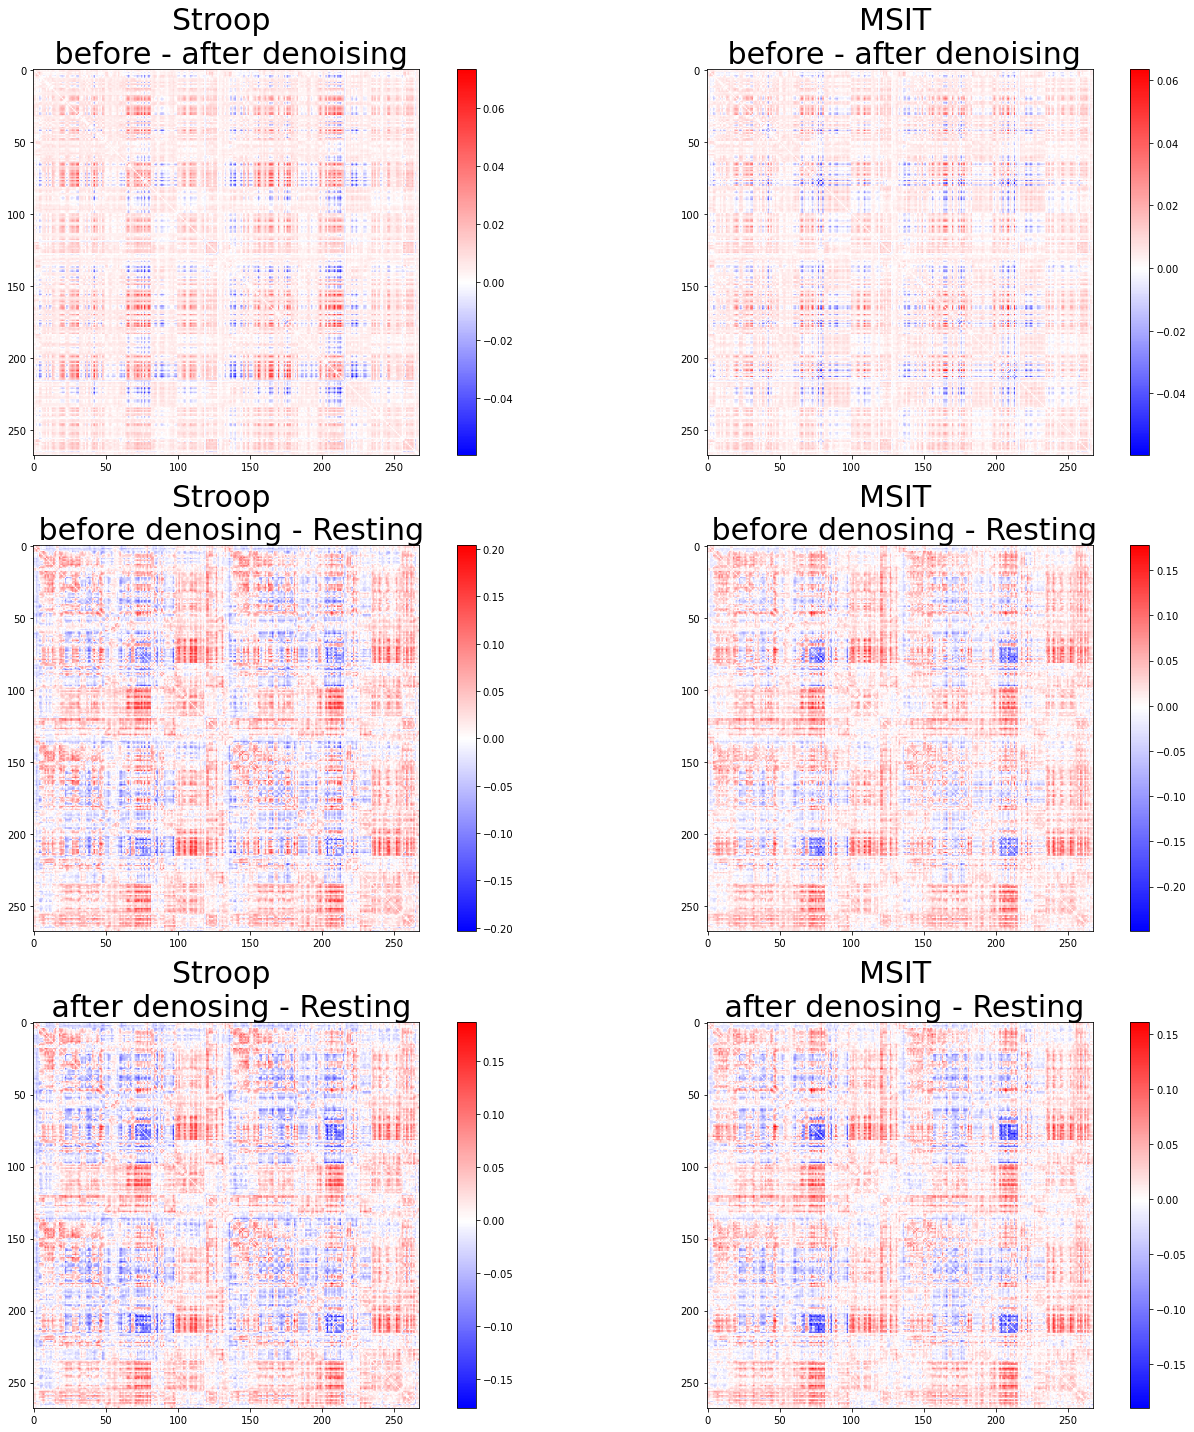

In [134]:
from matplotlib.colors import TwoSlopeNorm
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20,20))

im = axs[0, 0].imshow(squareform(diff_stroop_before_after), cmap=plt.cm.bwr, 
           norm=TwoSlopeNorm(vmin=np.min(diff_stroop_before_after), 
                             vcenter=0,
                             vmax=np.max(diff_stroop_before_after)))
axs[0, 0].set_title("Stroop \n before - after denoising", size=30)
fig.colorbar(im, ax=axs[0, 0])

im = axs[1, 0].imshow(squareform(diff_stroop_before_resting), cmap=plt.cm.bwr,
          norm = TwoSlopeNorm(vmin=np.min(diff_stroop_before_resting), 
                             vcenter=0,
                             vmax=np.max(diff_stroop_before_resting)))
axs[1, 0].set_title("Stroop \n before denosing - Resting", size=30)
fig.colorbar(im, ax=axs[1, 0])

im = axs[2, 0].imshow(squareform(diff_stroop_after_resting), cmap=plt.cm.bwr, 
          norm = TwoSlopeNorm(vmin=np.min(diff_stroop_after_resting), 
                             vcenter=0,
                             vmax=np.max(diff_stroop_after_resting)))
axs[2, 0].set_title("Stroop \n after denosing - Resting", size=30)
fig.colorbar(im, ax=axs[2, 0])

im = axs[0, 1].imshow(squareform(diff_msit_before_after), cmap=plt.cm.bwr, 
           norm=TwoSlopeNorm(vmin=np.min(diff_msit_before_after), 
                             vcenter=0,
                             vmax=np.max(diff_msit_before_after)))
axs[0, 1].set_title("MSIT \n before - after denoising", size=30)
fig.colorbar(im, ax=axs[0, 1])


im = axs[1, 1].imshow(squareform(diff_msit_before_resting), cmap=plt.cm.bwr,
          norm = TwoSlopeNorm(vmin=np.min(diff_msit_before_resting), 
                             vcenter=0,
                             vmax=np.max(diff_msit_before_resting)))
axs[1, 1].set_title("MSIT \n before denosing - Resting", size=30)
fig.colorbar(im, ax=axs[1, 1])

im = axs[2, 1].imshow(squareform(diff_msit_after_resting), cmap=plt.cm.bwr, 
          norm = TwoSlopeNorm(vmin=np.min(diff_msit_after_resting), 
                             vcenter=0,
                             vmax=np.max(diff_msit_after_resting)))
axs[2, 1].set_title("MSIT \n after denosing - Resting", size=30)
fig.colorbar(im, ax=axs[2, 1])

plt.tight_layout()

Reproduce Figure 5B of Cole's paper, using here however a bonferroni correction instead of FDR because we are using more than 3 times subjects than in Cole's study (75 vs 259)

In [169]:
# STROOP 
from statsmodels.stats.multitest import fdrcorrection, multipletests

pv_stroop_before_resting = []
t_stroop_before_resting = []
for a, b in zip(np.array(connectivity_stroop_before).T, np.array(connectivity_resting).T):
    t, p = ttest_rel(a, b)
    t_stroop_before_resting.append(t)
    pv_stroop_before_resting.append(p)
pv_stroop_before_resting = np.array(pv_stroop_before_resting)
t_stroop_before_resting = np.array(t_stroop_before_resting)
    
pv_stroop_after_resting = []
t_stroop_after_resting = []
for a, b in zip(np.array(connectivity_stroop_after).T, np.array(connectivity_resting).T):
    t, p = ttest_rel(a, b)
    t_stroop_after_resting.append(t)
    pv_stroop_after_resting.append(p)
pv_stroop_after_resting = np.array(pv_stroop_after_resting)
t_stroop_after_resting = np.array(t_stroop_after_resting)

pv_sig = multipletests(np.concatenate((pv_stroop_before_resting, pv_stroop_after_resting)))[0]
sig_stroop_before_resting = pv_sig[:len(pv_stroop_before_resting)]
sig_stroop_after_resting = pv_sig[len(pv_stroop_after_resting):]

pos_before = 100*sum(sig_stroop_before_resting*(t_stroop_before_resting>0))/len(sig_stroop_before_resting)
neg_before = 100*sum(sig_stroop_before_resting*(t_stroop_before_resting<0))/len(sig_stroop_before_resting)

pos_after = 100*sum(sig_stroop_after_resting*(t_stroop_after_resting>0))/len(sig_stroop_after_resting)
neg_after = 100*sum(sig_stroop_after_resting*(t_stroop_after_resting<0))/len(sig_stroop_after_resting)

print("Proportion of significant increased connections without denoising: %f" % pos_before)
print("Proportion of significant increased connections with denoising: %f" % pos_after)

print("Proportion of significant decreased connections without denoising: %f" % neg_before)
print("Proportion of significant decreased connections with denoising: %f" % neg_after)

Proportion of significant increased connections without denoising: 13.622897
Proportion of significant increased connections with denoising: 10.064844
Proportion of significant decreased connections without denoising: 4.047180
Proportion of significant decreased connections with denoising: 4.206496


In [170]:
# MSIT
pv_msit_before_resting = []
t_msit_before_resting = []
for a, b in zip(np.array(connectivity_msit_before).T, np.array(connectivity_resting).T):
    t, p = ttest_rel(a, b)
    t_msit_before_resting.append(t)
    pv_msit_before_resting.append(p)
pv_msit_before_resting = np.array(pv_msit_before_resting)
t_msit_before_resting = np.array(t_msit_before_resting)
    
pv_msit_after_resting = []
t_msit_after_resting = []
for a, b in zip(np.array(connectivity_msit_after).T, np.array(connectivity_resting).T):
    t, p = ttest_rel(a, b)
    t_msit_after_resting.append(t)
    pv_msit_after_resting.append(p)
pv_msit_after_resting = np.array(pv_msit_after_resting)
t_msit_after_resting = np.array(t_msit_after_resting)

pv_sig = multipletests(np.concatenate((pv_msit_before_resting, pv_msit_after_resting)))[0]
sig_msit_before_resting = pv_sig[:len(pv_msit_before_resting)]
sig_msit_after_resting = pv_sig[len(pv_msit_after_resting):]

pos_before = 100*sum(sig_msit_before_resting*(t_msit_before_resting>0))/len(sig_msit_before_resting)
neg_before = 100*sum(sig_msit_before_resting*(t_msit_before_resting<0))/len(sig_msit_before_resting)

pos_after = 100*sum(sig_msit_after_resting*(t_msit_after_resting>0))/len(sig_msit_after_resting)
neg_after = 100*sum(sig_msit_after_resting*(t_msit_after_resting<0))/len(sig_msit_after_resting)

print("Proportion of significant increased connections without denoising: %f" % pos_before)
print("Proportion of significant increased connections with denoising: %f" % pos_after)

print("Proportion of significant decreased connections without denoising: %f" % neg_before)
print("Proportion of significant decreased connections with denoising: %f" % neg_after)

Proportion of significant increased connections without denoising: 9.016714
Proportion of significant increased connections with denoising: 6.780703
Proportion of significant decreased connections without denoising: 3.278551
Proportion of significant decreased connections with denoising: 3.018615


Last: Compute similarity between correlation matrices from resting and task. In Cole's 2014, they found a large similarity between these. Something that we also reported in the paper with Daniele, as as to let us predict from one modalit the other

In [204]:
np.corrcoef(np.array(connectivity_stroop_before)[1,:],np.array(connectivity_resting)[1,:])

array([[1.        , 0.61917983],
       [0.61917983, 1.        ]])

Text(0.5, 1.0, 'MSIT-Resting Mean R = 0.613')

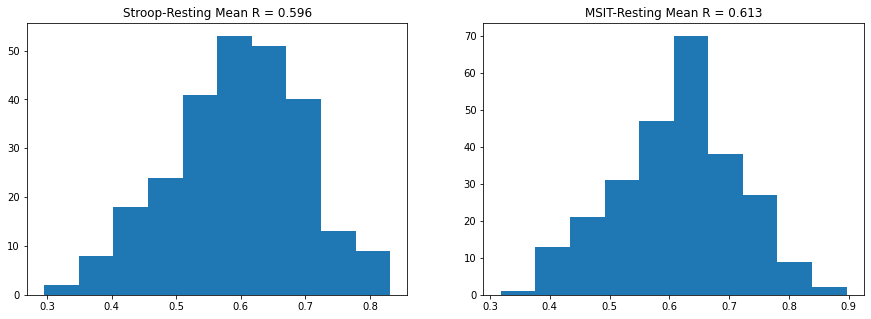

In [220]:
fig, axs=plt.subplots(ncols=2, figsize=(15, 5))

sim_stroop_resting = [np.corrcoef(a, b)[0,1] for (a,b) in zip(np.array(connectivity_stroop_after), np.array(connectivity_resting))]

axs[0].hist(sim_stroop_resting)
axs[0].set_title("Stroop-Resting Mean R = %.3f" % np.mean(sim_stroop_resting))

sim_msit_resting = [np.corrcoef(a, b)[0,1] for (a,b) in zip(np.array(connectivity_msit_after), np.array(connectivity_resting))]

axs[1].hist(sim_msit_resting)
axs[1].set_title("MSIT-Resting Mean R = %.3f" % np.mean(sim_msit_resting))

In [241]:
np.std(np.array(connectivity_resting), axis=1)

259

In [251]:
# Thre are some elements with a correlation == 1. This can be problematic or something to check why this happens
print(np.sum(np.array(connectivity_resting)==1))
print(np.sum(np.array(connectivity_stroop_before)==1))
print(np.sum(np.array(connectivity_stroop_after)==1))

print(np.sum(np.array(connectivity_resting)==1))
print(np.sum(np.array(connectivity_msit_before)==1))
print(np.sum(np.array(connectivity_msit_after)==1))

1
10
87
1
12
42


In [305]:
print(np.where(np.array(connectivity_stroop_after)==1)[0])
print(np.where(np.array(connectivity_msit_after)==1)[0])
print(np.where(np.array(connectivity_resting)==1)[0])

[ 16  16  16  16  16  16  16  16  16  16  16  16  16  16  16  16  16  16
  16  16  16  16  16  16  16  16  16  16  16  16  16  16  16  16  16  16
  16  16  16  16  16  16  16  16  16  16  16  16  16  16  16  16  16  16
  16  16  16  16  16  16  16  16  16  16  16  16 245 245 245 245 245 245
 245 245 245 245 245 245 245 245 245 251 251 251 251 251 251]
[  4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4
   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4
 245 245 245 245 245 245]
[246]


In [303]:
# Drop subject 16, 4, 245, 251 and 246?
# Some subjects had issues before task regression and now not. Why?

In [291]:
connectivity_resting[246]

array([ 0.51523946,  0.7540342 ,  0.25174428, ..., -0.11912206,
       -0.22734217,  0.40283268])

In [289]:
final_subjects[246]

2033.0

In [290]:
from nilearn.input_data import NiftiLabelsMasker
run_img = "../task-rest/preproc/sub-2033_ses-01_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
confounds = pd.read_csv("../task-rest/confounders/sub-2033_ses-01_task-rest_desc-confounds_regressors.tsv", sep="\t").filter(regex=confounders_regex).fillna(0)
foo = NiftiLabelsMasker(labels_img=atlas_file, high_pass=1/187., t_r=2, standardize=True).fit_transform(imgs=run_img, 
                                                                                                      confounds=confounds)
#

<ipython-input-226-093854994ec8>:5: RuntimeWarning: invalid value encountered in arctanh
  z_a = np.arctanh(a)
<ipython-input-226-093854994ec8>:5: RuntimeWarning: divide by zero encountered in arctanh
  z_a = np.arctanh(a)
<ipython-input-226-093854994ec8>:6: RuntimeWarning: invalid value encountered in arctanh
  z_b = np.arctanh(b)
<ipython-input-226-093854994ec8>:6: RuntimeWarning: divide by zero encountered in arctanh
  z_b = np.arctanh(b)
<ipython-input-226-093854994ec8>:17: RuntimeWarning: divide by zero encountered in arctanh
  sim_msit_resting = [np.corrcoef(np.arctanh(a), np.arctanh(b))[0,1] \
<ipython-input-226-093854994ec8>:17: RuntimeWarning: invalid value encountered in arctanh
  sim_msit_resting = [np.corrcoef(np.arctanh(a), np.arctanh(b))[0,1] \


Text(0.5, 1.0, 'MSIT-Resting Mean Z-fisher R = nan')

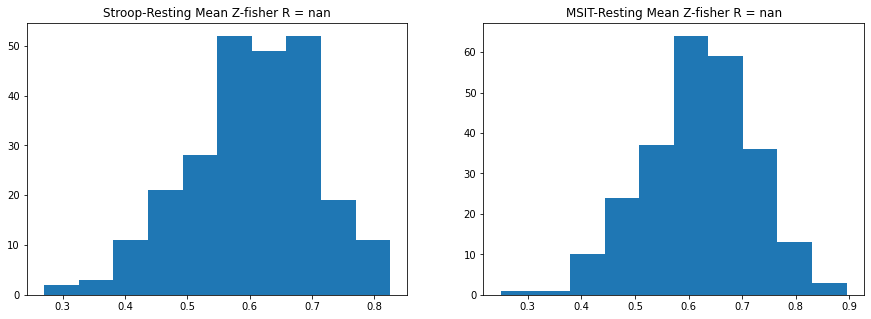

In [226]:
fig, axs=plt.subplots(ncols=2, figsize=(15, 5))

sim_stroop_resting = [] 
for (a,b) in zip(np.array(connectivity_stroop_after), np.array(connectivity_resting)):
    z_a = np.arctanh(a)
    z_b = np.arctanh(b)
    
    if np.any(np.isnan(z_a)):
        continue
    if np.any(np.isnan(z_b)):
        continue
    sim_stroop_resting.append(np.corrcoef(z_a, z_b)[0,1])
    
axs[0].hist(sim_stroop_resting)
axs[0].set_title("Stroop-Resting Mean Z-fisher R = %.3f" % np.mean(sim_stroop_resting))

sim_msit_resting = [np.corrcoef(np.arctanh(a), np.arctanh(b))[0,1] \
                    for (a,b) in zip(np.array(connectivity_msit_after), np.array(connectivity_resting))]

axs[1].hist(sim_msit_resting)
axs[1].set_title("MSIT-Resting Mean Z-fisher R = %.3f" % np.mean(sim_msit_resting))


In [198]:
We don't find those 

array([0.34510108, 0.65618757, 0.63852951, ..., 0.24836321, 0.17717509,
       0.60033249])

In [197]:
squareform(np.squeeze(image.load_img("../task-stroop/first-level-nilearn/edge_intercept/sub-2050/constant/cope.nii.gz").get_fdata()), 
           checks=False)

array([0.34521658, 0.65618757, 0.63852951, ..., 0.24856051, 0.17719397,
       0.60000568])